This notebook presents how to fit log Gaussian tuning curves to the data from the NSDsyn dataset. In this example, the data is first binned by eccentricity (0.5-1, 1-2, & 2-4 deg) and then averaged across stimulus classes. The tuning curves are fitted for each eccentricity bin. 

Related snakemake rules: `binning`, `fit_tuning_curves`

# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [8]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
e1, e2=0.5, 4
enum=7 #'log3'
lr = 0.005
max_epoch = 8000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
subj='subj01'
roi='V1'
voxels='pRFcenter'

# Load betas and experimental design information

In [4]:
subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'))
subj_df = subj_df.query('~names.str.contains("intermediate").values')


# 1. Binning

In [5]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')
subj_df['ecc_bin'] = tuning.bin_ecc(subj_df['eccentricity'], bin_list, bin_labels)
#bin_df = subj_df.groupby(['sub','vroinames','ecc_bin','freq_lvl','names']).mean().reset_index()
bin_df = tuning.summary_stat_for_ecc_bin(subj_df,
                                       to_group=['sub','vroinames','ecc_bin','freq_lvl','names'],
                                       to_bin=['betas', 'local_sf'],
                                       central_tendency='mean')

## Sanity check: Datapoints only

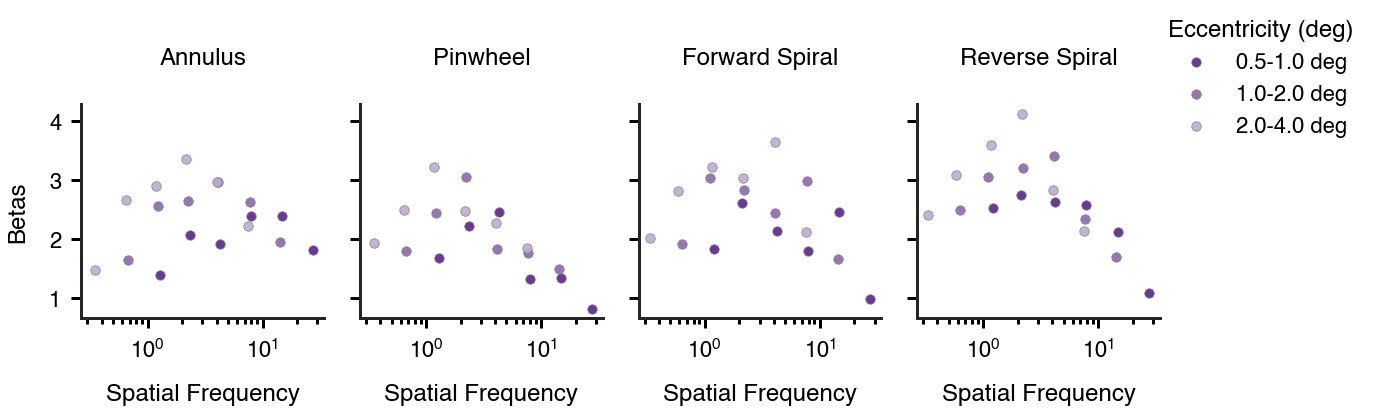

In [7]:
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
vis1D.plot_datapoints(bin_df, 'local_sf', 'betas', hue='ecc_bin', hue_order=bin_labels, 
                      col='names', col_order=stim_classes, 
                    height=6, aspect=0.7, lgd_title='Eccentricity (deg)',
                    palette=ecc_colors)

# 2. Fitting log Gaussian curves for every eccentricity bin

In [8]:
avg_bin_df = bin_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()


In [9]:
loss_history, model_history = pd.DataFrame({}), pd.DataFrame({})
for ecc_bin in avg_bin_df.ecc_bin.unique():
    print(f'{ecc_bin}')
    tmp = avg_bin_df.query('ecc_bin == @ecc_bin')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    tmp_loss_history, tmp_model_history = tuning.fit_tuning_curves(my_model, my_dataset, 
                                                                   max_epoch=100, print_every=50, 
                                                                   learning_rate=0.01)
    tmp_model_history['ecc_bin'] = ecc_bin
    tmp_loss_history['ecc_bin'] = ecc_bin
    model_history = pd.concat((model_history, tmp_model_history), axis=0)
    loss_history = pd.concat((loss_history, tmp_loss_history), axis=0)


0.5-1.0 deg
**epoch no.0 loss: 3.88222
**epoch no.49 loss: 2.59849
**epoch no.99 loss: 1.15669
**epoch no.100: Finished! final params {'slope': 2.076, 'mode': 1.692, 'sigma': 1.587}
Elapsed time: 0.07 sec 

1.0-2.0 deg
**epoch no.0 loss: 5.89247
**epoch no.49 loss: 4.49853
**epoch no.99 loss: 2.53081
**epoch no.100: Finished! final params {'slope': 1.18, 'mode': 2.434, 'sigma': 1.775}
Elapsed time: 0.05 sec 

2.0-4.0 deg
**epoch no.0 loss: 6.61654
**epoch no.49 loss: 4.48473
**epoch no.99 loss: 2.4692
**epoch no.100: Finished! final params {'slope': 1.529, 'mode': 1.371, 'sigma': 1.991}
Elapsed time: 0.05 sec 


# 3. Plotting the results

## 3.1. loss and model history checks 

In [103]:
args = ['class', 'lr', 'eph', 'dset', 'sub', 'roi', 'curbin']
l, m = [], []
for curbin, subj in itertools.product([0,1,2], subj_list):
    loss_file_name = f'loss-history_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    model_file_name =f'model-history_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    l.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', loss_file_name))
    m.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', model_file_name))


In [104]:
loss_df = utils.load_dataframes(l, *args)
model_df = utils.load_dataframes(m, *args)

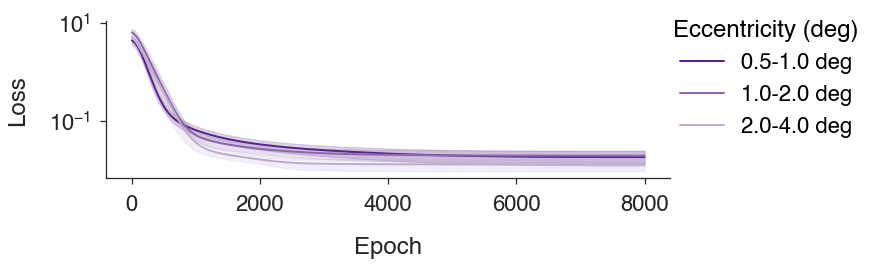

In [153]:
vis.plot_loss_history(loss_df[loss_df['epoch'] % 3 != 0], 
                      hue='ecc_bin', hue_order=bin_labels, 
                      lgd_title='Eccentricity (deg)', 
                      log_y=True, palette=ecc_colors, errorbar='se')

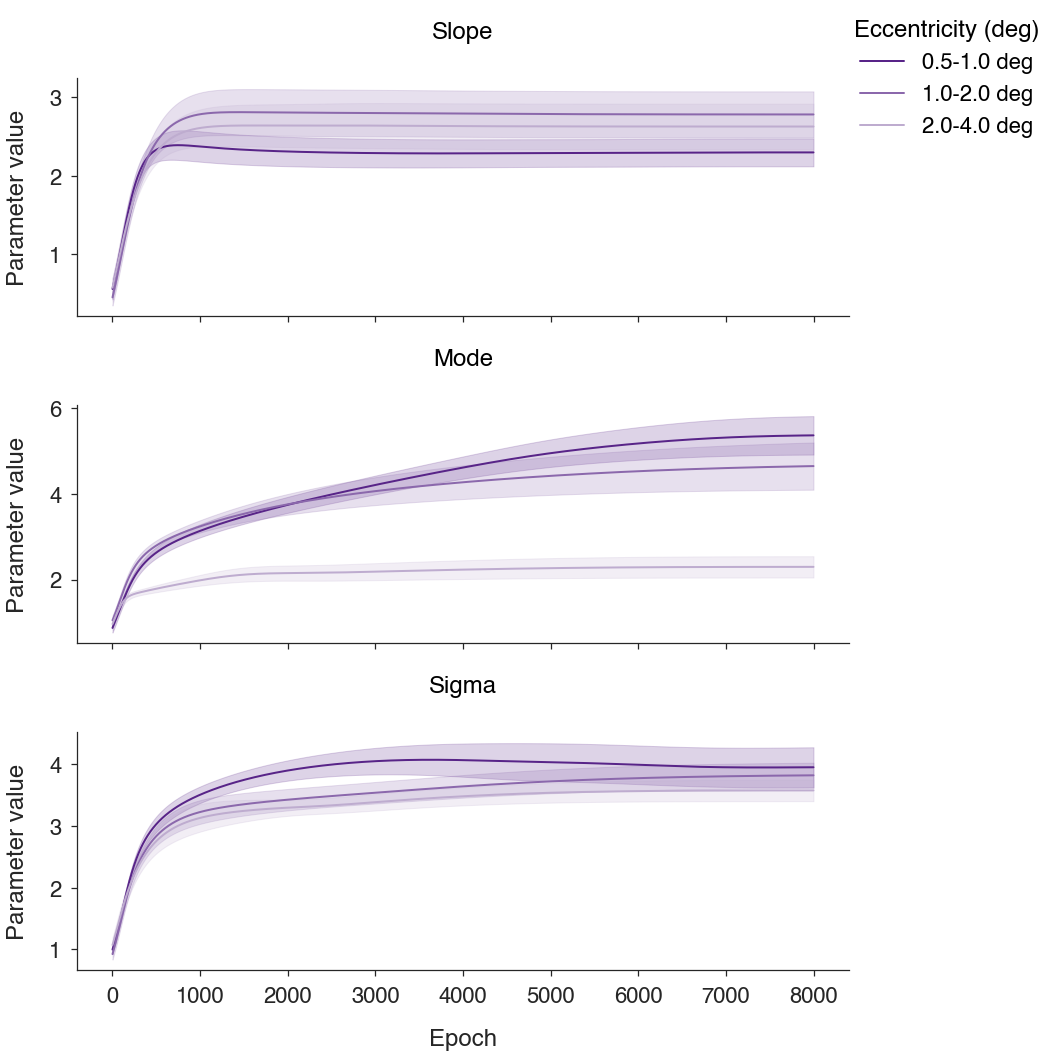

In [154]:
vis.plot_param_history(model_df[loss_df['epoch'] % 3 != 0], params=['slope','mode','sigma'],
                       hue='ecc_bin', hue_order=bin_labels, 
                       lgd_title='Eccentricity (deg)', errorbar='se',
                       palette=ecc_colors)

## 3.2 Tuning curves

### Load the data and the model

In [12]:
f, m = [], []
for subj, roi in itertools.product(subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-log3_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))

subj_df = utils.load_dataframes(f)
subj_df = subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

In [13]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, [0,1,2]):
    file_name = f'model-params_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-log3_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

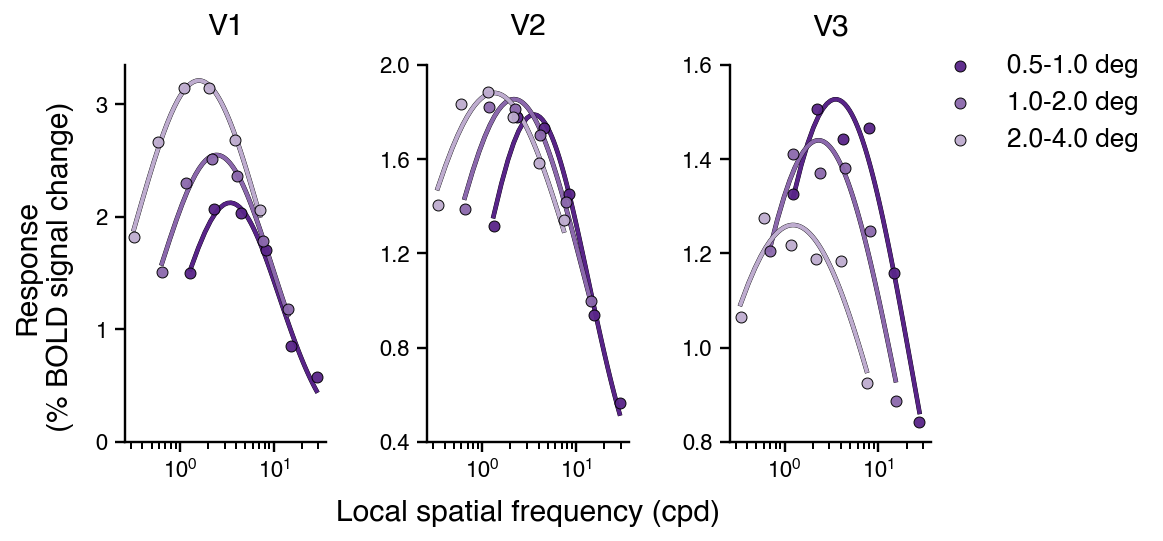

In [92]:
tmp_subj_df = subj_df.query('sub == "subj06"')
tmp_tuning_df = tuning_df.query('sub == "subj06"')
fig_name = os.path.join(output_dir,"figures", "sfp_model","results_1D", "nsdsyn", f'tuning_class_avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-log3_curbin-all_dset-nsdsyn_sub-subj06_roi-all_vs-pRFsize.pdf')
vis1D.plot_sf_curves(df=tmp_subj_df, x='local_sf', y='betas', hue='ecc_bin',
                     col='vroinames', params_df=tmp_tuning_df, lgd_title=None,
                     save_path=fig_name)

## 3.3 Preferred period as function of eccentricity

We plot preferred period as a function of eccentricity averaged across subjects. 
To calculate the average, we use precision as weights for each subject. 

### Load precision for each subject

In [425]:
file_list = []
for subj, roi in itertools.product(subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
    
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [427]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
enum='log3'
pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, np.arange(0, 3)):
    file_name = f'model-params_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

In [428]:
tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])

fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'mode', 'precision', groupby=['vroinames'])

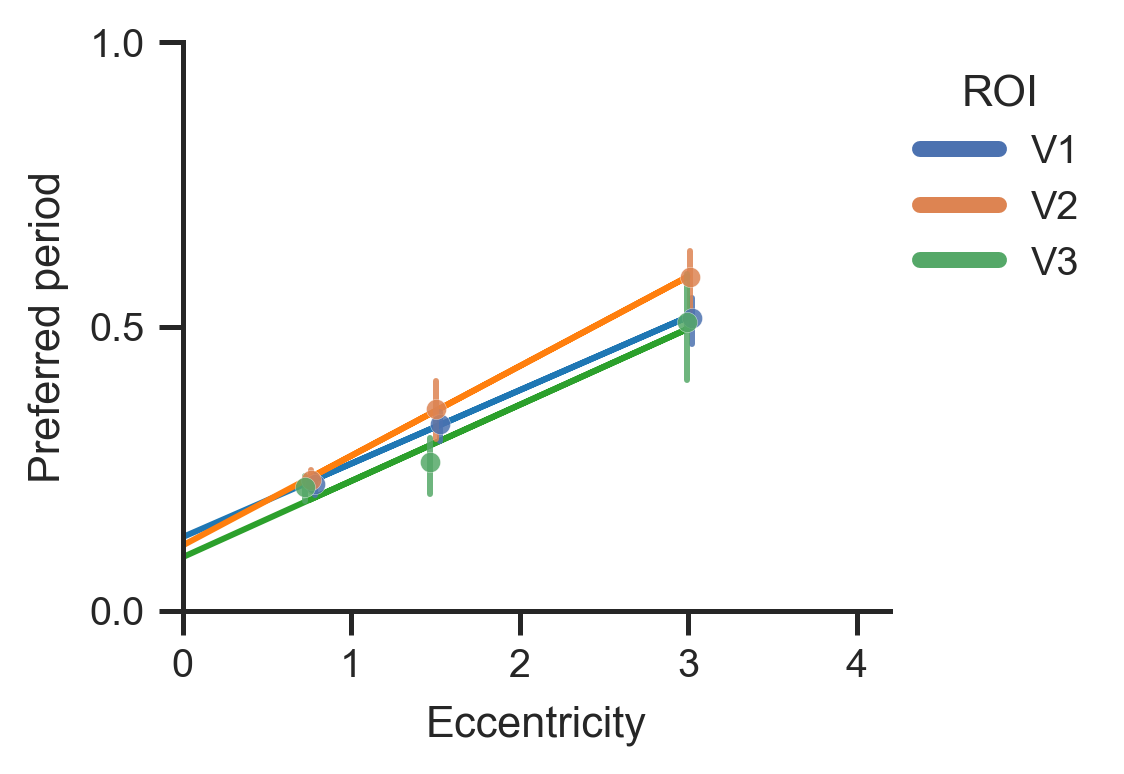

In [429]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, 
                                sf_peak='mode', precision='precision', hue='vroinames', 
                                hue_order=['V1','V2','V3'], fit_df=fit_df, lgd_title='ROI')


# Each stimulus class's preferred period as a function of eccentricity

In [430]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, np.arange(0, 3)):
    for stim_class in stim_classes:
        stim_class = stim_class.replace(' ', '-')
        file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
        pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

In [431]:
tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'mode', 'precision', groupby=['vroinames','names'])

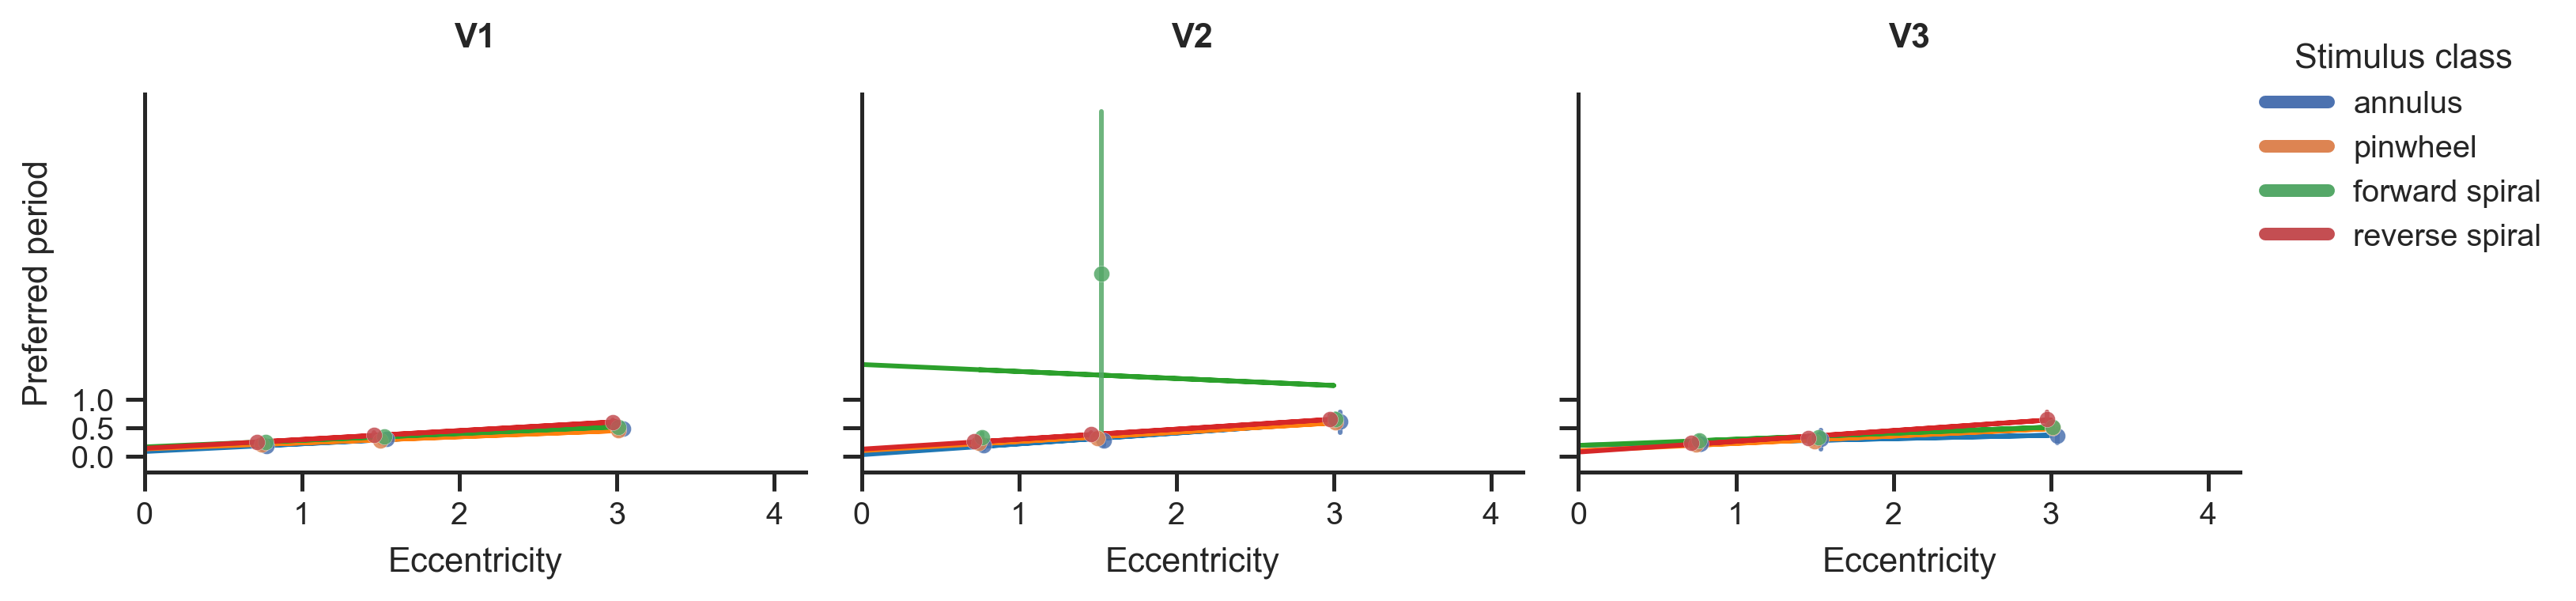

In [432]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, col='vroinames', col_order=roi_list,
                                sf_peak='mode', precision='precision', hue='names', width=7,
                                hue_order=stim_classes, fit_df=fit_df, lgd_title='Stimulus class')

,slope,mode,sigma,sub,names,dset,lr_rate,max_epoch,vroinames,e1,e2,nbin,curbin,ecc_bin,precision,ecc,pp
18,2.253163,4.858312,5.665891,subj01,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,1.548457,1.5,0.205833
54,2.173597,0.039047,8.928065,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.881836,1.5,25.609896
90,2.940261,6.501976,4.422491,subj03,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.748543,1.5,0.153799
126,2.078771,5.209052,6.341847,subj04,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.872796,1.5,0.191974
162,3.303940,2.230087,3.844835,subj05,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.737055,1.5,0.448413
198,1.595648,2.169053,2.837367,subj06,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,1.866259,1.5,0.461031
234,4.036446,2.548296,3.419777,subj07,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.585363,1.5,0.392419
270,3.146333,0.849075,5.066793,subj08,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.637120,1.5,1.177752


<AxesSubplot:xlabel='precision', ylabel='pp'>

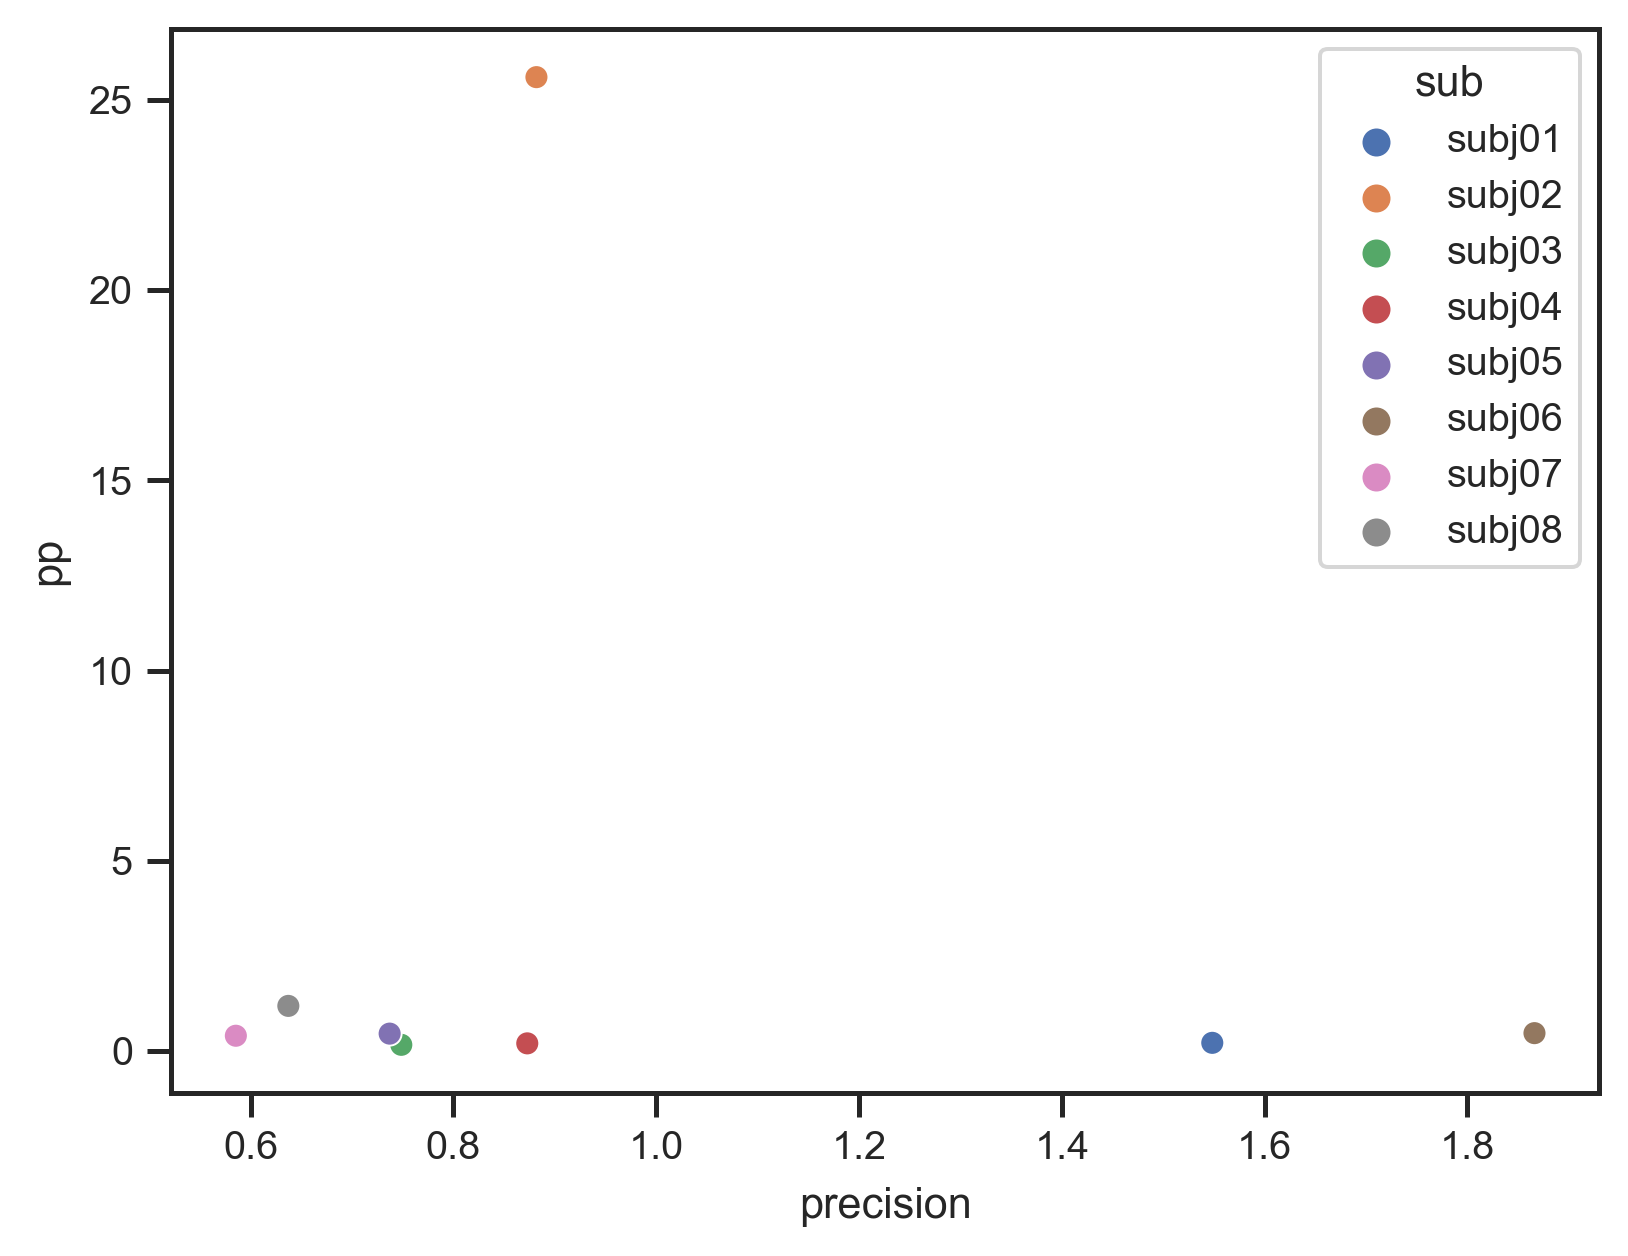

In [439]:
test = tuning_with_precision_df.query('vroinames == "V2" & names == "forward spiral" & curbin == "1"')
sns.scatterplot(data=test, x='precision', y='pp', hue='sub')

In [ ]:
test = tuning_with_precision_df.query('vroinames == "V2" & names == "forward spiral" & curbin == 1')

In [448]:
import h5py

stim_set = ('/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata_stimuli/stimuli/nsdsynthetic/nsdsynthetic_stimuli.hdf5')
with h5py.File(stim_set, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    w = f['imgBrick'].value


Keys: <KeysViewHDF5 ['imgBrick']>


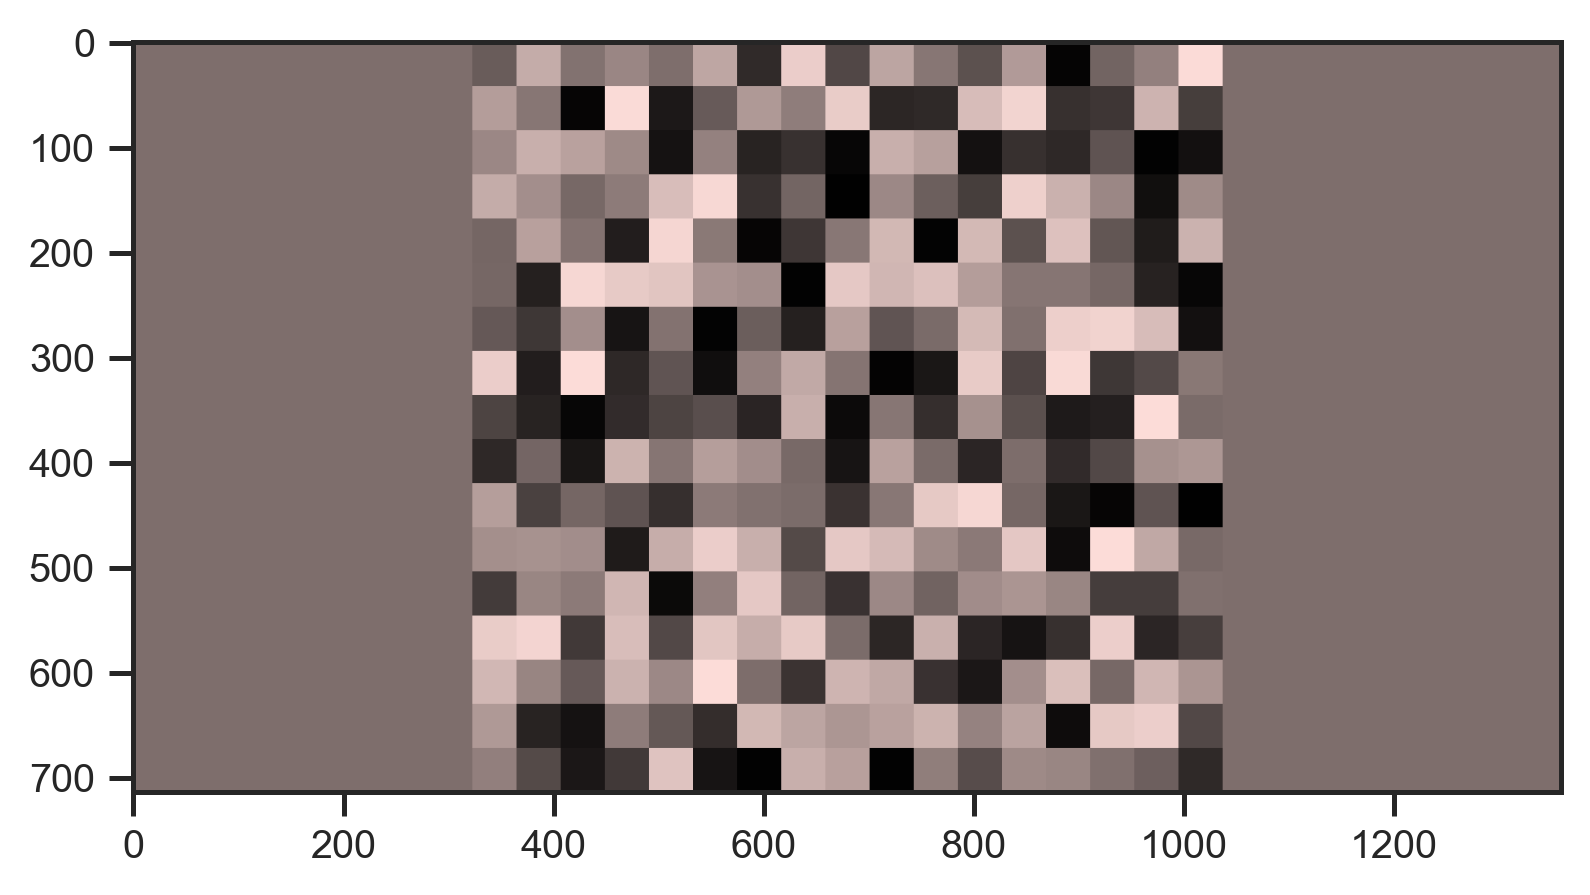

In [453]:
plt.imshow(w[4,:,:,:])

# Baseline? 

In [458]:
from sfp_nsdsyn import prep

nsd_dir = '/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/'
fs_dir = '/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'
# inputs
subj = utils.sub_number_to_string(1, dataset='nsdsyn')
hemi = 'lh'
design_mat = os.path.join(nsd_dir, 'nsddata', 'experiments', 'nsdsynthetic', 'nsdsynthetic_expdesign.mat')
betas = os.path.join(nsd_dir, 'nsddata_betas', 'ppdata', subj, 'nativesurface', prep._get_beta_folder_name(3),
                     f'{hemi}.betas_nsdsynthetic.hdf5')
stim_info = os.path.join(nsd_dir, 'nsdsyn_stim_description.csv')
rois = [os.path.join(fs_dir, subj, 'label', f'{hemi}.prf-{roi}.mgz')
        for roi in ["visualrois", "eccrois"]]
rois_vals = [[1,2],[1,2,3,4,5]]
prfs = [os.path.join(fs_dir, subj, 'label', f'{hemi}.prf{prf_param}.mgz')
        for prf_param in ["eccentricity", "angle", "size"]]


In [491]:
w

,voxel,stim_idx,task,betas,eccentricity,angle,size,visualrois,vroinames,eccrois,hemi,sub
0,0,0,avg,1.625000,1.370705,5.098831,84.840942,2.0,V1,3.0,lh,subj01
1,0,1,avg,0.490000,1.370705,5.098831,84.840942,2.0,V1,3.0,lh,subj01
2,0,2,avg,2.103334,1.370705,5.098831,84.840942,2.0,V1,3.0,lh,subj01
3,0,3,avg,0.668333,1.370705,5.098831,84.840942,2.0,V1,3.0,lh,subj01
4,1,0,avg,1.620000,1.270235,5.079485,170.579865,2.0,V1,3.0,lh,subj01
...,...,...,...,...,...,...,...,...,...,...,...,...
15707,7090,3,avg,1.848333,1.432514,1.847050,0.572932,1.0,V1,3.0,rh,subj01
15708,7091,0,avg,2.751667,1.425122,1.867685,0.813257,1.0,V1,3.0,rh,subj01
15709,7091,1,avg,1.873333,1.425122,1.867685,0.813257,1.0,V1,3.0,rh,subj01
15710,7091,2,avg,2.966667,1.425122,1.867685,0.813257,1.0,V1,3.0,rh,subj01


In [509]:
w = pd.read_csv('/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/baseline/baseline_sub-subj01_roi-V1_vs-pRFcenter.csv')

e = pd.read_csv('/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/dset-nsdsyn_sub-subj01_roi-V1_vs-pRFcenter.csv')

print(w['voxel'].nunique())
print(e['voxel'].nunique())

4024
4024


In [506]:
w

,voxel,stim_idx,task,betas,eccentricity,angle,size,visualrois,vroinames,eccrois,hemi,sub
0,0,0,avg,1.625000,1.370705,5.098831,84.840942,2.0,V1,3.0,lh,subj01
1,0,1,avg,0.490000,1.370705,5.098831,84.840942,2.0,V1,3.0,lh,subj01
2,0,2,avg,2.103334,1.370705,5.098831,84.840942,2.0,V1,3.0,lh,subj01
3,0,3,avg,0.668333,1.370705,5.098831,84.840942,2.0,V1,3.0,lh,subj01
4,1,0,avg,1.620000,1.270235,5.079485,170.579865,2.0,V1,3.0,lh,subj01
...,...,...,...,...,...,...,...,...,...,...,...,...
16091,7090,3,avg,1.848333,1.432514,1.847050,0.572932,1.0,V1,3.0,rh,subj01
16092,7091,0,avg,2.751667,1.425122,1.867685,0.813257,1.0,V1,3.0,rh,subj01
16093,7091,1,avg,1.873333,1.425122,1.867685,0.813257,1.0,V1,3.0,rh,subj01
16094,7091,2,avg,2.966667,1.425122,1.867685,0.813257,1.0,V1,3.0,rh,subj01


In [496]:
e.voxel.nunique()

3953

In [ ]:
subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'))
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')
subj_df['ecc_bin'] = tuning.bin_ecc(subj_df['eccentricity'], bin_list, bin_labels)
#bin_df = subj_df.groupby(['sub','vroinames','ecc_bin','freq_lvl','names']).mean().reset_index()
bin_df = tuning.summary_stat_for_ecc_bin(subj_df,
                                         to_group=['sub', 'vroinames', 'ecc_bin', 'freq_lvl', 'names'],
                                         to_bin=['betas', 'local_sf'],
                                         central_tendency='mean')